In [ ]:
%load_ext autoreload
%autoreload 2

### Load libraries and paths

In [2]:
import sys
sys.path.append("../../..")

In [295]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import pymc as pm 

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from config.config import BASE_PATH, PATH_TO_PATH_CONFIG_FILE, PROJECT_EPSG
from src.utils import load_paths_from_yaml, replace_base_path
from src.modeling.encodings import (convert_aspect_to_cardinal_direction, 
                                    convert_population_to_classes, 
                                    convert_elevation_to_classes, 
                                    convert_slope_to_classes, 
                                    apply_encoding, 
                                    naturraumregionen_encoding, 
                                    map_to_binary)
from src.modeling.utils import temporal_train_test_split, save_model, load_model
from src.modeling.bayesian_models import create_blr_v2, create_st_blr_v2, create_bnn, create_st_intercept_blr_v2
from src.modeling.predictions import BinaryClassification, BinaryClassificationBNN

In [4]:
paths = load_paths_from_yaml(PATH_TO_PATH_CONFIG_FILE)
paths = replace_base_path(paths, BASE_PATH)

### Read in data

In [5]:
# read in training data
training_data = gpd.read_file(paths["training_data"])
training_data.date = pd.to_datetime(training_data.date)

# read in Naturraumregionen
naturraumregionen = gpd.read_file(paths["naturraumregionen"])
naturraumregionen.to_crs(PROJECT_EPSG, inplace=True)

### Data Cleaning & Preparation

In [6]:
# rename columns
training_data.rename(columns={"farmyard_d": "farmyard_density", 
                              "hiking_ds": "hikingtrail_density", 
                              "forest_ds": "forestroad_density", 
                              "rail_dens": "railway_density", 
                              "foresttype": "forest_type", 
                              "pop_dens": "population_density"}, inplace=True)

training_data = training_data.sjoin(naturraumregionen.loc[:, ["EINHEIT", "geometry"]])
training_data.drop(columns=["index_right"], inplace=True)

# create season column (0 = winter (1,2,3), 1 = spring (4,5,6), 2 = sommer (7,8,9), 3 = winter (10,11,12))
training_data["season"] = (training_data.date.dt.month -1) // 3 

# encode features into predefined classes
training_data["naturraumregionen_encoded"] = training_data["EINHEIT"].apply(apply_encoding, mapping=naturraumregionen_encoding)
training_data["elevation_encoded"] = training_data["elevation"].apply(convert_elevation_to_classes)
training_data["slope_encoded"] = training_data["slope"].apply(convert_slope_to_classes)
training_data["aspect_encoded"] = training_data["aspect"].apply(convert_aspect_to_cardinal_direction)
training_data["population_encoded"] = training_data["population_density"].apply(convert_population_to_classes)

# binarize features
training_data["farmyard_density_bin"] = training_data["farmyard_density"].apply(map_to_binary)
training_data["forestroad_density_bin"] = training_data["forestroad_density"].apply(map_to_binary)
training_data["railway_density_bin"] = training_data["railway_density"].apply(map_to_binary)
training_data["hikingtrail_density_bin"] = training_data["hikingtrail_density"].apply(map_to_binary)

# deal with missing data in forest type feature
training_data["forest_type"].fillna(6, inplace=True)
training_data["forest_type"] = training_data["forest_type"].astype(int)

/tmp/ipykernel_45731/3938864487.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  training_data["forest_type"].fillna(6, inplace=True)


### Temporal train test split

In [7]:
X_train_unprocessed, X_test_unprocessed = temporal_train_test_split(training_data, "date", 0.7)
y_train, y_test = X_train_unprocessed["fire"], X_test_unprocessed["fire"]

print("The following gives us the split date:")
print(X_train_unprocessed.date.max())
print(X_test_unprocessed.date.min())

The following gives us the split date:
2016-05-09 00:00:00
2016-05-11 00:00:00


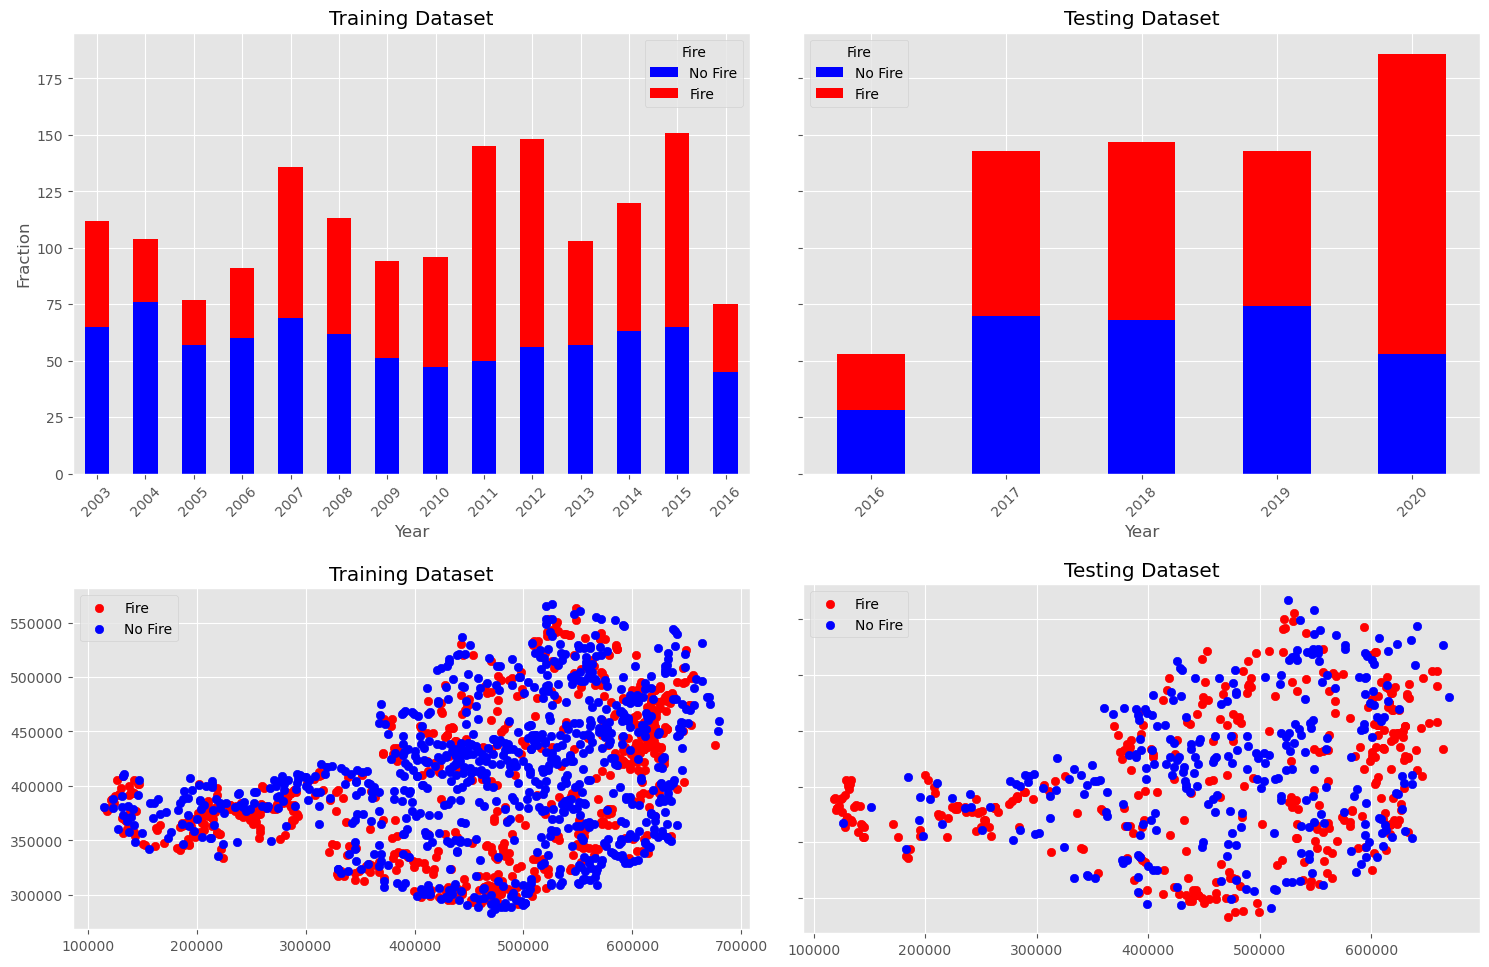

In [17]:
# Plotting the distribution of fire and no-fire samples for train and test set

fractions_train = X_train_unprocessed.groupby("year").fire.value_counts().unstack()
fractions_test = X_test_unprocessed.groupby("year").fire.value_counts().unstack()

plt.style.use('ggplot')
fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharey="row")

# Plot for training dataset
fractions_train.plot(kind='bar', stacked=True, ax=axs[0][0], color=["blue", "red"])
axs[0][0].set_xlabel('Year')
axs[0][0].set_ylabel('Fraction')
axs[0][0].set_title('Training Dataset')
axs[0][0].legend(title='Fire', labels=['No Fire', 'Fire'])
axs[0][0].tick_params(axis='x', rotation=45)

# Plot for testing dataset
fractions_test.plot(kind='bar', stacked=True, ax=axs[0][1], color=["blue", "red"])
axs[0][1].set_xlabel('Year')
axs[0][1].set_ylabel('Fraction')
axs[0][1].set_title('Testing Dataset')
axs[0][1].legend(title='Fire', labels=['No Fire', 'Fire'])
axs[0][1].tick_params(axis='x', rotation=45)


# Create two separate GeoDataFrames for fire and no fire in training dataset
gdf_fire_train = X_train_unprocessed[X_train_unprocessed['fire'] == 1]
gdf_no_fire_train = X_train_unprocessed[X_train_unprocessed['fire'] == 0]

# Create two separate GeoDataFrames for fire and no fire in testing dataset
gdf_fire_test = X_test_unprocessed[X_test_unprocessed['fire'] == 1]
gdf_no_fire_test = X_test_unprocessed[X_test_unprocessed['fire'] == 0]

# Plot for training dataset
axs[1][0].set_title('Training Dataset')
gdf_fire_train.plot(ax=axs[1][0], color='red', label='Fire')
gdf_no_fire_train.plot(ax=axs[1][0], color='blue', label='No Fire')

# Plot for testing dataset
axs[1][1].set_title('Testing Dataset')
gdf_fire_test.plot(ax=axs[1][1], color='red', label='Fire')
gdf_no_fire_test.plot(ax=axs[1][1], color='blue', label='No Fire')

# Add legends
axs[1][0].legend()
axs[1][1].legend()

plt.tight_layout()
plt.savefig(r"../../../results/train_test_distribution.png")
plt.show()


### Feature Preprocessing

In [10]:
# feature processing for BLR and ST_BLR
preprocessor_blr = ColumnTransformer(
    transformers=[
        ('std_scaler', StandardScaler(), ["ffmc"])
    ],
    remainder='drop',
)

preprocessor_blr.fit(X_train_unprocessed)
train_ffmc_scaled = preprocessor_blr.transform(X_train_unprocessed)
test_ffmc_scaled = preprocessor_blr.transform(X_test_unprocessed)

X_train = X_train_unprocessed.copy()
X_test = X_test_unprocessed.copy()
X_train["ffmc"] = train_ffmc_scaled
X_test["ffmc"] = test_ffmc_scaled

# feature processing for BNN
features_to_scale = ['ffmc', 'farmyard_density',
       'hikingtrail_density', 'forestroad_density', 'railway_density',
       'elevation', 'slope', 'population_density']
features_bnn_ohe = ['aspect_encoded', 'forest_type']

preprocessor_bnn = ColumnTransformer(
    transformers=[
        ('std_scaler', StandardScaler(), features_to_scale),
        ('ohe', OneHotEncoder(), features_bnn_ohe)
    ],
    remainder='drop',
)

# scaler
preprocessor_bnn.fit(X_train_unprocessed)
X_train_bnn = preprocessor_bnn.fit_transform(X_train_unprocessed)
X_test_bnn = preprocessor_bnn.transform(X_test_unprocessed)

### Modeling

In [11]:
coords = {"elevation_classes": [0, 1, 2, 3, 4, 5], 
          "slope_classes": [0, 1, 2, 3, 4], 
          "aspect_classes": [0, 1, 2, 3, 4, 5, 6, 7],
          "forest_type_classes": [0, 1, 2, 3, 4, 5, 6], 
          "population_classes": [0, 1, 2, 3, 4, 5], 
          "farmyard_density_classes": [0, 1], 
          "forestroad_density_classes": [0, 1], 
          "railway_density_classes": [0, 1], 
          "hikingtrail_density_classes": [0, 1], 
          "spatial_groups": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 
          "temporal_groups": [0, 1, 2, 3]}

In [18]:
# Create simple Bayesian Log Reg Model
model_blr = create_blr_v2(X_train, y_train, coords)
with model_blr:
    approx = pm.fit(n=20000, random_seed=0)
    blr_idata = approx.sample()
    pm.compute_log_likelihood(blr_idata)

save_model("../../../models/blr_v2.pkl", model_blr, blr_idata)

/home/david/miniconda3/envs/ignite_pymc_env/lib/python3.12/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Output()

Finished [100%]: Average Loss = 786.51


Output()

In [25]:
model_st_intercept_blr = create_st_intercept_blr_v2(X_train, y_train, coords, "naturraumregionen_encoded", "season")
with model_st_intercept_blr:
    approx = pm.fit(n=20000, random_seed=0)
    st_intercept_blr_idata = approx.sample()
    pm.compute_log_likelihood(st_intercept_blr_idata)

save_model("../../../models/st_intercept_blr_v2.pkl", model_st_intercept_blr, st_intercept_blr_idata)

/home/david/miniconda3/envs/ignite_pymc_env/lib/python3.12/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Output()

Finished [100%]: Average Loss = 779.44


Output()

In [24]:
# Spatio temporal Bayesian Logistic Regression Model
model_st_blr = create_st_blr_v2(X_train, y_train, coords, "naturraumregionen_encoded", "season")
with model_st_blr:
    approx = pm.fit(n=20000, random_seed=0)
    st_blr_idata = approx.sample()
    pm.compute_log_likelihood(st_blr_idata)

save_model("../../../models/st_blr_v2.pkl", model_st_blr, st_blr_idata)

/home/david/miniconda3/envs/ignite_pymc_env/lib/python3.12/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Output()

Finished [100%]: Average Loss = 1,231.4


Output()

In [21]:
model_bnn = create_bnn(X_train_bnn, y_train)

with model_bnn:
    approx = pm.fit(n=20000, random_seed=0)
    bnn_idata = approx.sample()

save_model("../../../models/bnn.pkl", model_bnn, bnn_idata)

/home/david/miniconda3/envs/ignite_pymc_env/lib/python3.12/site-packages/pymc/data.py:416: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(


Output()

Finished [100%]: Average Loss = 889.04


### Out-of-sample prediction

In [29]:
# open saved models
model_blr, idata_blr = load_model("../../../models/blr_v2.pkl")
model_st_blr, idata_st_blr = load_model("../../../models/st_blr_v2.pkl")
model_st_intercept_blr, idata_st_intercept_blr = load_model("../../../models/st_intercept_blr_v2.pkl")
model_bnn, idata_bnn = load_model("../../../models/bnn.pkl")

In [27]:
y_dummy = [0 for i in y_test]
X_new_blr = {
    "elevation": X_test.elevation_encoded,
    "slope": X_test.slope_encoded,
    "aspect": X_test.aspect_encoded,
    "forestroad_density": X_test.forestroad_density_bin,
    "railway_density": X_test.railway_density_bin,
    "hikingtrail_density": X_test.hikingtrail_density_bin,
    "farmyard_density": X_test.farmyard_density_bin,
    "population": X_test.population_encoded,
    "forest_type": X_test.forest_type,
    "ffmc": X_test.ffmc,
    "fire": y_dummy
    }

X_new_st_blr = X_new_blr.copy()
X_new_st_blr["spatial_groups_idx"] = X_test.naturraumregionen_encoded
X_new_st_blr["temporal_groups_idx"] = X_test.season

In [96]:
seed = 0

# predictions for blr model
blr_prediction_obj = BinaryClassification(model_blr, idata_blr, X_new_blr, seed, "y_pred", "p")
blr_prediction_obj.extend_trace()
blr_preds = blr_prediction_obj.predict()

# predictions for st_intercept_blr model
st_intercept_blr_prediction_obj = BinaryClassification(model_st_intercept_blr, idata_st_intercept_blr, X_new_st_blr, seed, "y_pred", "p")
st_intercept_blr_prediction_obj.extend_trace()
st_intercept_blr_preds = st_intercept_blr_prediction_obj.predict()

# predictions for st_blr model
st_blr_prediction_obj = BinaryClassification(model_st_blr, idata_st_blr, X_new_st_blr, seed, "y_pred", "p")
st_blr_prediction_obj.extend_trace()
st_blr_preds = st_blr_prediction_obj.predict()

# predictions for bnn model
bnn_prediction_obj = BinaryClassificationBNN(model_bnn, idata_bnn, X_test_bnn, seed, "y_pred", "p")
bnn_prediction_obj.extend_trace()
bnn_preds = bnn_prediction_obj.predict()


Sampling: [y_pred]


Output()

Sampling: [y_pred]


Output()

Sampling: [y_pred]


Output()

Sampling: [y_pred]


Output()

#### Calculate overall model performance

In [ ]:

print("BLR Accuracy: ", accuracy_score(y_test, blr_preds.y_pred))
print("BLR Precision: ", precision_score(y_test, blr_preds.y_pred))
print("BLR Recall: ", recall_score(y_test, blr_preds.y_pred))
print("HDI width: ", blr_preds.hdi_width.mean())

print("---------------------------------")

print("ST Intercept BLR Accuracy: ", accuracy_score(y_test, st_intercept_blr_preds.y_pred))
print("ST Intercept BLR Precision: ", precision_score(y_test, st_intercept_blr_preds.y_pred))
print("ST Intercept BLR  Recall: ", recall_score(y_test, blr_preds.y_pred))
print("HDI width: ", st_intercept_blr_preds.hdi_width.mean())

print("---------------------------------")

print("ST BLR Accuracy: ", accuracy_score(y_test, st_blr_preds.y_pred))
print("ST BLR Precision: ", precision_score(y_test, st_blr_preds.y_pred))
print("ST BLR Recall: ", recall_score(y_test, blr_preds.y_pred))
print("HDI width: ", st_blr_preds.hdi_width.mean())

print("---------------------------------")

print("BNN Accuracy: ", accuracy_score(y_test, bnn_preds.y_pred))
print("BNN Precision: ", precision_score(y_test, bnn_preds.y_pred))
print("BNN Recall: ", recall_score(y_test, blr_preds.y_pred))
print("HDI width: ", bnn_preds.hdi_width.mean())

BLR Accuracy:  0.7708333333333334
BLR Precision:  0.8260869565217391
BLR Recall:  0.7519788918205804
HDI width:  0.19818444432718985
---------------------------------
ST Intercept BLR Accuracy:  0.78125
ST Intercept BLR Precision:  0.8333333333333334
ST Intercept BLR  Recall:  0.7519788918205804
HDI width:  0.23065761596410356
---------------------------------
ST BLR Accuracy:  0.7470238095238095
ST BLR Precision:  0.7943661971830986
ST BLR Recall:  0.7519788918205804
HDI width:  0.4192507396808526
---------------------------------
BNN Accuracy:  0.7544642857142857
BNN Precision:  0.786096256684492
BNN Recall:  0.7519788918205804
HDI width:  0.27872929902007837


#### Calculate performance for every test year

In [135]:

years = ["2016", "2017", "2018", "2019", "2020"]
result_dic = {}

for preds_df, model in [(blr_preds, "blr"), (st_intercept_blr_preds, "st_intercept_blr"), (st_blr_preds, "st_blr"), (bnn_preds, "bnn")]:

    preds = preds_df.copy()
    preds["year"] = X_test.year.values
    preds["y_true"] = y_test.values

    result_dic[model] = {}

    for year in years:
        data = preds[preds["year"] == year]
        result_dic[model][year] = {}
        result_dic[model][year]["accuracy"] = accuracy_score(data["y_true"], data["y_pred"])
        result_dic[model][year]["precision"] = precision_score(data["y_true"], data["y_pred"])
        result_dic[model][year]["recall"] = recall_score(data["y_true"], data["y_pred"])
        result_dic[model][year]["f1"] = f1_score(data["y_true"], data["y_pred"])
        result_dic[model][year]["mean_hdi_width"] = data.hdi_width.mean()


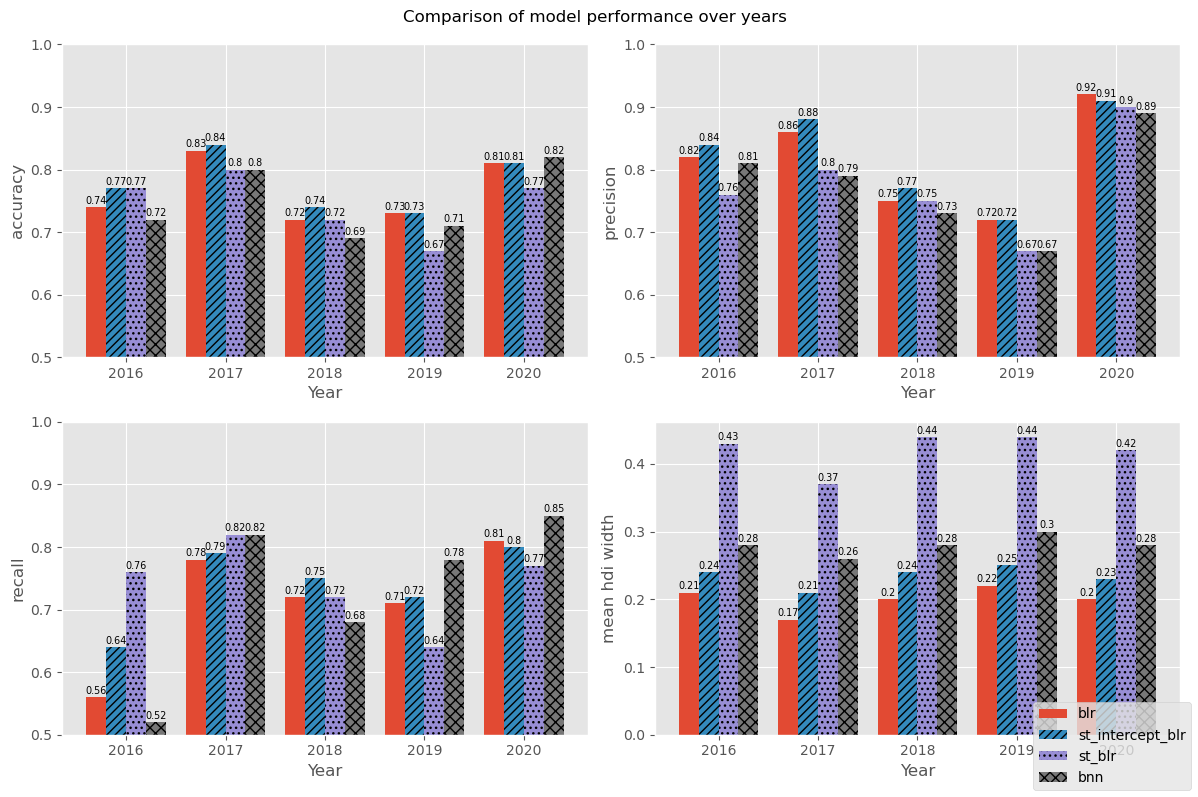

In [132]:
patterns = ['', '////', '...', 'xxx']
metrics = ["accuracy", "precision", "recall", "mean_hdi_width"]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.subplots_adjust(hspace=0.5)

for i, metric in enumerate(metrics):
    dic = {
        "blr": [round(result_dic["blr"][year][metric], 2) for year in result_dic["blr"]],
        "st_intercept_blr": [round(result_dic["st_intercept_blr"][year][metric], 2) for year in result_dic["st_intercept_blr"]],
        "st_blr": [round(result_dic["st_blr"][year][metric], 2) for year in result_dic["st_blr"]],
        "bnn": [round(result_dic["bnn"][year][metric], 2) for year in result_dic["bnn"]]
    }

    x = np.arange(len(years))  # the label locations
    width = 0.20  # the width of the bars
    multiplier = 0

    ax = axs[i // 2, i % 2]

    for j, (attribute, measurement) in enumerate(dic.items()):
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute, hatch=patterns[j])
        ax.bar_label(rects, padding=1, fontsize='x-small')  # Adjust font size here
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(metric)
    ax.set_xlabel('Year')
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(years)
    if metric != "mean_hdi_width":
        ax.set_ylim(0.5, 1)
    else:
        ax.set_ylabel("mean hdi width")

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')
plt.suptitle(f'Comparison of model performance over years')

plt.tight_layout()
plt.savefig("../../../results/model_performance_over_years.png")
plt.show()



#### Model performance for subgroup season & Naturregion

In [292]:
spatial_groups = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
temporal_groups = [0, 1, 2, 3]

results_dic_spatial = {}
results_dic_temporal = {}


def calculate_metrics(result_dic: dict, model: str, groups:list, group_type: str):

    result_dic[model] = {}
    result_dic[model]["accuracy"] = {}
    result_dic[model]["precision"] = {}
    result_dic[model]["recall"] = {}
    result_dic[model]["hdi"] = {}

    for gp in groups:
        data = preds[preds[group_type] == gp]
        result_dic[model]["accuracy"][gp] = accuracy_score(data["y_true"], data["y_pred"])
        result_dic[model]["precision"][gp] = precision_score(data["y_true"], data["y_pred"])
        result_dic[model]["recall"][gp] = recall_score(data["y_true"], data["y_pred"])
        result_dic[model]["hdi"][gp] = data.hdi_width.mean()
    
    return result_dic


for preds_df, model in [(blr_preds, "blr"), (st_intercept_blr_preds, "st_intercept_blr"), (st_blr_preds, "st_blr"), (bnn_preds, "bnn")]:

    preds = preds_df.copy()
    preds["spatial_group"] = X_test.naturraumregionen_encoded.values
    preds["temporal_group"] = X_test.season
    preds["y_true"] = y_test.values

    results_dic_spatial = calculate_metrics(results_dic_spatial, model, spatial_groups, "spatial_group")
    results_dic_temporal = calculate_metrics(results_dic_temporal, model, temporal_groups, "temporal_group")

df_performance_spatial_groups = pd.DataFrame.from_dict({(outerKey, innerKey): values
                                                    for outerKey, innerDict in results_dic_spatial.items()
                                                    for innerKey, values in innerDict.items()}, orient='columns')

df_performance_temporal_groups = pd.DataFrame.from_dict({(outerKey, innerKey): values
                                                    for outerKey, innerDict in results_dic_temporal.items()
                                                    for innerKey, values in innerDict.items()}, orient='columns')

    

In [293]:
df_performance_temporal_groups

blr                               st_intercept_blr            \
   accuracy precision    recall       hdi         accuracy precision   
0  0.773810  0.838710  0.650000  0.174178         0.761905  0.812500   
1  0.765854  0.798077  0.754545  0.194168         0.780488  0.803738   
2  0.714286  0.769231  0.666667  0.216260         0.785714  0.846154   
3  0.794118  0.714286  0.769231  0.178547         0.852941  0.750000   

                         st_blr                                     bnn  \
     recall       hdi  accuracy precision    recall       hdi  accuracy   
0  0.650000  0.216691  0.785714  0.843750  0.675000  0.386399  0.773810   
1  0.781818  0.227059  0.726829  0.732759  0.772727  0.420584  0.726829   
2  0.733333  0.231389  0.785714  0.764706  0.866667  0.430729  0.714286   
3  0.923077  0.206018  0.852941  0.900000  0.692308  0.336161  0.794118   

                                 
  precision    recall       hdi  
0  0.862069  0.625000  0.249597  
1  0.741071  0.754545  0.280549  
2  0.718750  0.766667  0.312522  
3  0.800000  0.615385  0.250410

In [245]:
naturraumregionen["EINHEIT_encoded"] = naturraumregionen["EINHEIT"].apply(apply_encoding, mapping=naturraumregionen_encoding)


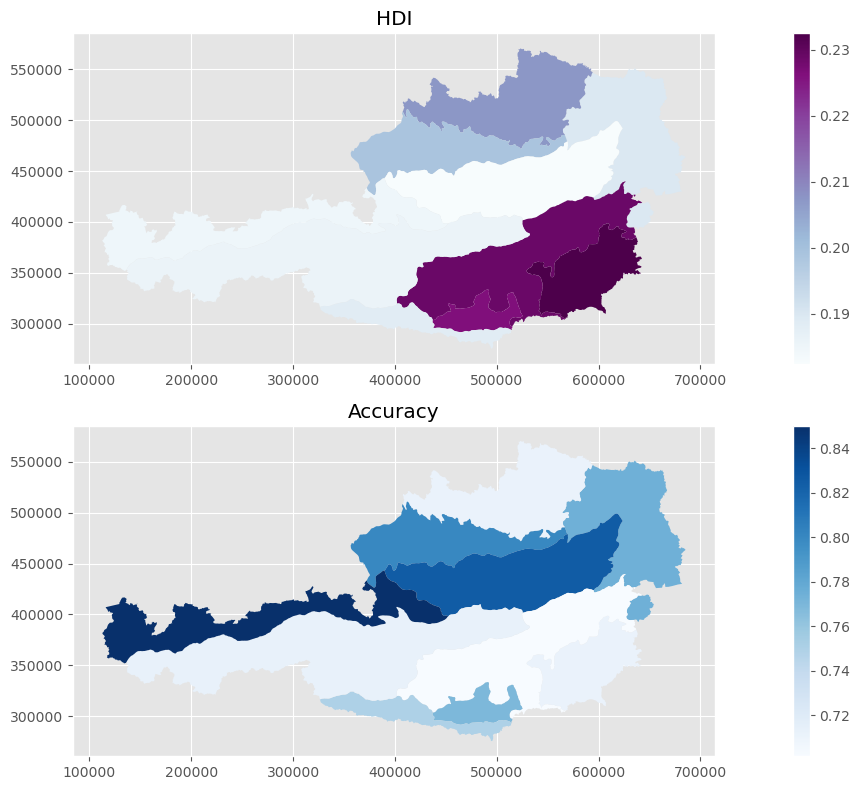

In [269]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data and plots
performance_per_spatial_unit = pd.merge(naturraumregionen, df.blr.reset_index(), left_on="EINHEIT_encoded", right_on="index")

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# Plot for "hdi"
performance_per_spatial_unit.plot(column="hdi", cmap="BuPu", k=5, legend=True, ax=axes[0])
axes[0].set_title('HDI')

# Plot for "accuracy"
performance_per_spatial_unit.plot(column="accuracy", cmap="Blues", k=5, legend=True, ax=axes[1])
axes[1].set_title('Accuracy')

plt.tight_layout()
plt.show()
